# Machine Learning / Fruit Identification

## Introduction

In this project, I am going to work with images of fruit. The goal is to identify the type of fruit from the image.

To do so, we will use some machine learning concepts :
- Feature extraction to turn an image into a vector of features
- PCA (Principal Component Analysis)
- Training a [kNN (k Nearest Neighbours)](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) -- classifiers

## Dataset information

We will use the [*Fruits-360* image dataset](https://github.com/Horea94/Fruit-Images-Dataset). This dataset contains over 60'000 images, so we shall only use a fraction of it to show that even with a relatively small amount of data we can get accurate results. Also it would take too much time to use the whole set.

## Note about OpenCV

We will use the OpenCV image processing library to extract some features from the images. If it is not already done, you can install it using anaconda with the following command :

    $ conda install opencv
    
You should then be able to import the OpenCV python module, called **cv2**.

In [0]:
import os
import cv2
import pandas as pd
import numpy as np
import numpy.ma as ma
import numpy.linalg as la
import skimage
import skimage.io
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

## Dataset overview
Before doing this step you must copy the compressed file "fruits.zip" data in the colab space:
### left panel -> Files ->UPLOAD
Or uncomment the following cell if you copied the data to your drive account



In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!cp 'drive/My Drive/Colab Notebooks/fruit_project/fruits.zip' .

Mounted at /content/drive


In [0]:
if os.path.exists('fruits.zip'):
  !unzip 'fruits.zip'
else:
  print('You must upload the data first!')

Archive:  fruits.zip
replace Data/Images/apple0_100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
from matplotlib.colors import hsv_to_rgb
from matplotlib.colors import rgb_to_hsv

# Data path
DIR = 'Data/'

# Unserialise data
meta = pd.io.pickle.read_pickle(os.path.join(DIR, 'meta.pkl'))

'''
 Loads an image from a given filename
'''
def load_img(name):
    img = skimage.io.imread(os.path.join(DIR, 'Images', name))
    img = skimage.img_as_ubyte(img)
    img = ma.masked_where(img == 0, img)

    # same mask for all 3 axes, none for the moment
    mask = np.all(img == 0, axis=2)
    img = ma.array(img)
    
    return img

The meta dataframe contains information for each image :

- *basename* is the filename of the image. 
- *classid* is the class. We selected 3 classes from the original dataset.

In [0]:
meta.iloc[:len(meta)]

You can use the *load_img* function to load an image.

In [0]:
# Show 3 example images
examples = [384, 1200, 1600]

plt.figure(figsize=(10, 3))
for i, idx in enumerate(examples): 
    plt.subplot(1, 3, i + 1)
    img = load_img(meta.iloc[idx]['basename'])
    plt.title(meta.iloc[idx]['classid'])
    plt.imshow(img.filled(1))
 

In [0]:
# The classes we will work with
print(np.unique(meta['classid']))

In [0]:
# You can plot some examples images for a given species
import random
examples = np.flatnonzero(meta['classid'] == 'apple')

for idx in random.sample(list(examples), 3):
    plt.figure()
    img = load_img(meta.iloc[idx]['basename'])
    plt.title(meta.iloc[idx]['classid'])
    plt.imshow(img.filled(1))

## Feature extraction

So, we have images of fruits and we want to train a classifier to automatically determine the type.

What should we use as input vectors for our classifier ?

The bruteforce approach could be to use a flattened version of all the image pixels (you concatenate all the rows in the image). Since we have images that have a size of 100x100, this would result in 10'000 (100*100) dimensional input vectors.

For most classifiers, this is way too many dimensions. Also, this would mean that if you translate your image by one pixel, the input vector will change dramatically. 

The better approach is to extract features to represent each image. If we ask you to manually classify those images, what will you look at ? Color ? The general shape of the fruit (i.e. elongated, round) ?

We will try to extract features that allow our classifier to use the same kind of hints that a human would use. We will start with *colour*, that is to say we extract a histogram of each colour channel (red, blue and green).

In [0]:
def colour_histogram(img, plot=False):
  result = []
  color = ('b','g','r') 
  
  if plot:
    plt.figure()
    
  for i,col in enumerate(color):
      hist = cv2.calcHist([img],[i],None,[256],[0,255])
      
      if plot:
        plt.plot(hist,color = col)
        plt.xlim([0,256])
      
      result.append(hist.astype(int))
  
  if plot:
      plt.show()
  
  return result

# Let's see if it works
example_number = 1950
img = load_img(meta.iloc[example_number]['basename'])

# Which fruit is it?
print(meta.iloc[example_number]['classid'])

# Extract histogram
c = colour_histogram(img, plot=True)

Okay so now we can perform the colour histogram function on different examples:

In [0]:
examples = [1, 513, 950, 1400]

for i, idx in enumerate(examples): 
    img = load_img(meta.iloc[idx]['basename'])
    print(meta.iloc[idx]['classid'])
    c = colour_histogram(img, plot=True)

## Feature reduction with PCA

We can see that the histogtam changes quite a lot between different fruit types. This is good news. It means that we can probably differentiate fruits quite simply using these features.

We have now reduced the feature amount from 30'000, to 768 (3x256, 3 colour channels and 256 different possible values). This is stilll quite a lot of features. What we can do to reduce this quantity is to use a method called [**Principal component analysis**](https://https://en.wikipedia.org/wiki/Principal_component_analysis) or **PCA**.

This is a way of extracting the features that differentiate the class types. Our samples currently have 768 features, but let's take another example. If we have 3 features and we only want 2, we can use PCA in order to determine which two features are most important in differentiating our classes.

For example we could take average colour for each channel: average red, average green and average blue. Technically apples and oranges are indistinguishable in the blue channel, so the PCA would probably eliminate this component.

(In reality it is a lot more complicated than this, but this explanation is enough to understand the principal)

#Train and evaluate a k-NN classifier

This involves :

- Compute the feature vector of each image (by concatenating individual features of the image).
- Build an $n$ x $m$ data matrix $X$ with the feature vectors of all the images, where $n$ is the number of images and $m$ the number of features.
- Reduce the number of features using **PCA**
- Build an integer vector $y$ of length $n$, containing the target class for each image. *sklearn.preprocessing.LabelEncoder* is useful for converting text labels into integers.
- Split your dataset into training and test : X_train, X_test, y_train, y_test. *sklearn.cross_validation* has useful utility functions for that.
- Normalizing your data. *sklearn.preprocessing.MinMaxScaler* might be useful (or other similar scaler classes)
- Build a classifier with *sklearn.neighbors.KNeighborsClassifier* on your training dataset and evaluate on your test dataset.


In [0]:
'''

KNN Code, feature matrix creation

'''
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
minmax = preprocessing.MinMaxScaler()
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

class KNN:
  def __init__(self):
    self.X = []
    self.X_reduce = []
    self.classnames = []
    self.y = []
    self.Xtrain = []
    self.Xtest = []
    self.ytrain = []
    self.ytest = []
    self.skf = None
    self.classifier = None
    self.PCA = None
    
  def build_feature_matrix(self, components):
    self.X = []
    # For each image
    for idx in range(0,len(meta)): 
      # Feature vector for this image
      fv = []

      # Load this image
      img = load_img(meta.iloc[idx]['basename'])

      # Add features to feature vector
      hist = colour_histogram(img, plot=False)
      for k in range (0, len(hist)):
        for kk in range (0, len(hist[k])):
          fv.append(int(hist[k][kk]))
          
      # Add to matrix
      self.X.append(fv)

    self.X = minmax.fit_transform(self.X)
    self.pca = PCA(n_components=components).fit(self.X)
    self.X_reduce = self.pca.transform(self.X)
  
  def build_class_vector(self):
    for idx in range(0, len(meta)):
      # Create a vector of the class names
      self.classnames.append(meta.iloc[idx]['classid'])
    
    # Associate class names with integers
    le.fit(self.classnames)
    #print le.classes_
    self.y = le.transform(self.classnames)
    
  def split_data(self):
    self.skf = StratifiedKFold(2, False, None)
    Xtrain_indexes, Xtest_indexes = self.skf.split(self.X_reduce, self.y)

    # Create vectors for training
    for i in range (0, len(Xtrain_indexes[0])):
      self.Xtrain.append(self.X_reduce[Xtrain_indexes[0][i]])
      self.ytrain.append(self.y[Xtrain_indexes[0][i]])

    # Create vectors for testing
    for i in range (0, len(Xtest_indexes[0])):
      self.Xtest.append(self.X_reduce[Xtest_indexes[0][i]])
      self.ytest.append(self.y[Xtest_indexes[0][i]])

  def train(self, neighbours):
    # Create a classifier for the training
    self.classifier = KNeighborsClassifier(n_jobs=-1,n_neighbors=neighbours,weights='uniform')
    # Train algorithm with training set
    self.classifier.fit(self.Xtrain, self.ytrain)


I first transformed all of the classes of the classes into an integer vector. This integer vector (y) contains a number for every different class of fruit.

What I did next was essentially add all of the following features for every leaf into a 2D vector (X).
  
  I then attempted a PCA analysis of it, to create X_reduce.
  
  This data is then split into a training set and a test set.
  
A classifier is set for kNN algorithms, fitting 1 neighbour.

In [0]:
# Create the classifer
knn = KNN()

# Build y, as an integer vector
knn.build_class_vector()

# Build a feature matrix, using PCA to get only 25 features
knn.build_feature_matrix(25)

# Split the data into training and testing
knn.split_data()

# Train kNN for 70 neighbours, using training data
knn.train(70)

# Predict the classes for the testing data
ypred = knn.classifier.predict(knn.Xtest)

# Performance

We then execute a performance analysis to see how accurate the predicitons are:

In [0]:
# performance evaluation.                        - for lencoder see sklearn.preprocessing.LabelEncoder
import sklearn.metrics as skmetrics
from sklearn.metrics import confusion_matrix

report = skmetrics.classification_report(knn.ytest,ypred,
                                         labels=np.arange(len(le.classes_)),
                                         target_names=le.classes_)
confmat = confusion_matrix(knn.ytest, ypred)

We can then plot a confusion matrix in order to visualise the accuracy:

In [0]:
def plot_confusion_matrix(confmat, labels_names, ax=None, cmap=None):
    """Utility function to plot a confusion matrix"""
    if ax is None:
        ax = plt.subplot(111)
    cmim = ax.matshow(confmat, interpolation='nearest', cmap=cmap)

    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.annotate(str(confmat[i, j]), xy=(j, i),
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=8)
    ax.set_xticks(np.arange(confmat.shape[0]))
    ax.set_xticklabels([labels_names[l] for l in range(confmat.shape[0])], rotation='vertical')
    ax.set_yticks(np.arange(confmat.shape[1]))
    _ = ax.set_yticklabels([labels_names[l] for l in range(confmat.shape[1])])
    ax.set_xlabel('predicted label')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('true label')
    plt.colorbar(cmim, shrink=0.7, orientation='horizontal', pad=0.01)

In [0]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(confmat, le.classes_, cmap=cm.gray_r)

In [0]:
print(report)

As we can see the confusion matrix is perfect, we have a precision of 100% for each class in our test data. The only problem is that our input data set is *very* biased. The lighting is the same for every image, as well as the positioning. I don't think the algorithm will perform so well in the real world.

## Real World Performance 

Let's upload some images of fruit from different links and see how the algorithm performs on real data.

We have to compress these images down to 100x100 pixels to be sure to have histogram values that aren't too large.

Uncomment whicherver image you would like to use.

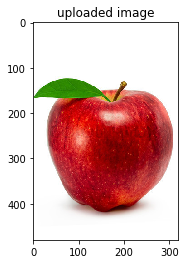

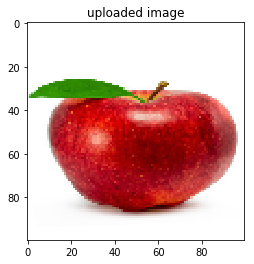

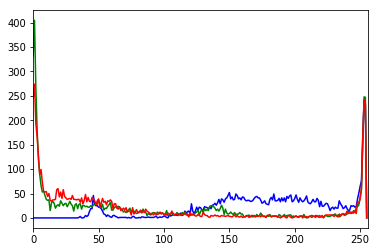

['orange']


In [0]:
import urllib

def url_to_image(url):
  # download the image, convert it to a NumPy array, and then read
  # it into OpenCV format
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  
  # Shuffle the image from RGB to BGR
  image = image[:,:,::-1]
  return image

# Bananas
#link = 'https://farm2.static.flickr.com/1074/861964348_18aa86b713.jpg'
#link = 'https://farm1.static.flickr.com/24/46490159_3db8b2b53f.jpg'
#link = 'https://farm1.static.flickr.com/123/358583729_602a6988e1.jpg'
#link = 'https://farm3.static.flickr.com/2091/2349603063_1849b4b7fd.jpg'

# Apples
link = 'https://primaoliva.com/wp-content/uploads/2015/11/Red-Apple-Balsamic-Vinegar.jpg'
#link = 'https://raw.githubusercontent.com/Horea94/Fruit-Images-Dataset/master/Training/Apple%20Red%201/142_100.jpg'
#link = 'https://raw.githubusercontent.com/Horea94/Fruit-Images-Dataset/master/Training/Apple%20Red%201/10_100.jpg'

# Oranges
#link = 'https://harvesttotable.com/wp-content/uploads/2007/02/Orange-Navel.jpg'
#link = 'https://raw.githubusercontent.com/Horea94/Fruit-Images-Dataset/master/Test/Orange/r_9_100.jpg'
#link = 'https://farm1.static.flickr.com/65/182317874_e7f922ae8b.jpg'

# Get image
img = url_to_image(link)

# Plot original image
plt.figure()
plt.title('uploaded image')
plt.imshow(img)

# Create new image, resized to 100x100 and plot
newimg = cv2.resize(img,(int(100),int(100)))
plt.figure()
plt.title('uploaded image')
plt.imshow(newimg)

# Get the histogram
hist = colour_histogram(newimg, plot=True)

# Create a "matrix" with one sample to test
test_value = []
fv = []
for k in range (0, len(hist)):
  for kk in range (0, len(hist[k])):
    fv.append(int(hist[k][kk]))
test_value.append(fv)

# Perform the PCA
test_reduce= knn.pca.transform(test_value)

# Predict the class
predicted = knn.classifier.predict(test_reduce)
print(le.classes_[predicted])

# Results

The results show us that a 100% accuracy on the test data does not mean your algorithm performs well in the real world. Essentially what is needed is more preprocessing on the images, such as masking. This would allow for contour detection, which in turn could be used to calculate the following types of features:
- Eccentricity
- Convexity
- Circularity ratio
- Curvature

Using these features, we could then identify the shape of the fruit in question.

However I think that this project is a good starting point for machine learning and helps one to understand how the process works in general.